## Cargar librerías y datos

In [27]:
%matplotlib inline      
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm,spearmanr,describe
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_validate, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,ConfusionMatrixDisplay,precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from patsy import dmatrices
import time
import backtrader as bt
from statistics import mean
sns.set_style('whitegrid')     ###quizas comentar esta parte

## Preparar datos

In [2]:
ventanadetiempo=250    #se usaran input muestras para fitear el modelo
ventana_historia_hacia_atras=203  #Cuantos dias hacia atras hacer la simulacion  #notar que se entregaran el input+1 fairvalues
dias_a_predecir=30  # cambiar nombre
dt=1    # 
ventana_tiempo_media_movil=30             #separar inputs de la parte de cargar datos  #enfatizar en que momento se hace el ventana_tiempo_media_movil 
df=pd.read_excel("Data_CLP_BBG.xlsx",sheet_name=1)
df = df[df.columns.drop(list(df.filter(regex='Index.1')))]
df.drop_duplicates()
df=df.interpolate()                 #Interpolate missing values
df=df.dropna(axis=0)
df=df.dropna().reset_index(drop=True)
df=df.iloc[::dt, :]     
df.reset_index(drop=True,inplace=True)
df=df.set_index("Dates")
returns = df.pct_change() 
dflog = np.log(1+returns)
dflog=dflog.add_suffix(" log_returns")
dflog=dflog.interpolate()
dflog=dflog.dropna(axis=0)
dfma=df.rolling(ventana_tiempo_media_movil).mean()
dfma=dfma.add_suffix(" Media_móvil_{}_días".format(ventana_tiempo_media_movil))
df_delta=df.diff(periods=1)

### Elegir target y features

In [3]:
target="CLP Curncy"  #Elegir target         #unir los dos dataframes
features=['MXN Curncy', 'BRL Curncy', 'EUR Curncy']    # ver esta parte
features.append(target)
dftest=df.loc[:,features]
dftest=dftest.reindex(columns=list(dftest.columns)[list(dftest.columns).index(target)+1:] +list(dftest.columns)[:list(dftest.columns).index(target)+1])
variables_log=[i + " log_returns" for i in features]
dflog_test=dflog.loc[:,variables_log]
dflog_test=dflog_test.reindex(columns=list(dflog_test.columns)[list(dflog_test.columns).index(target+" log_returns")+1:] +list(dflog_test.columns)[:list(dflog_test.columns).index(target+" log_returns")+1])
features.pop(-1)

'CLP Curncy'

# Target

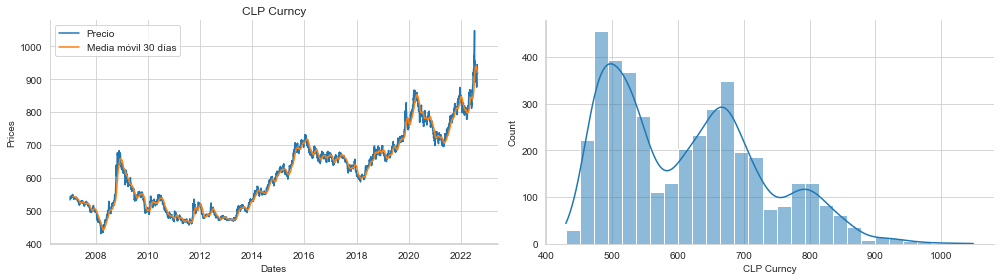

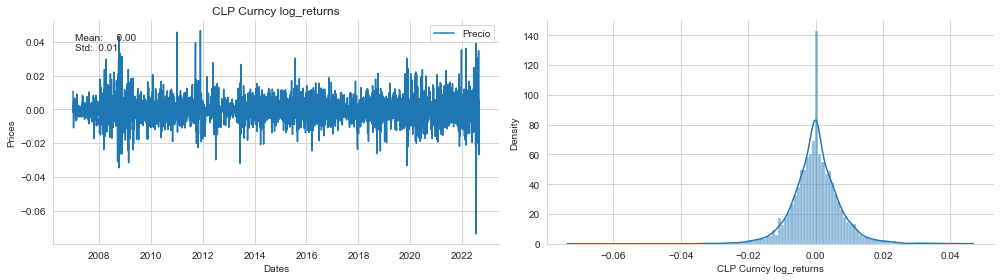

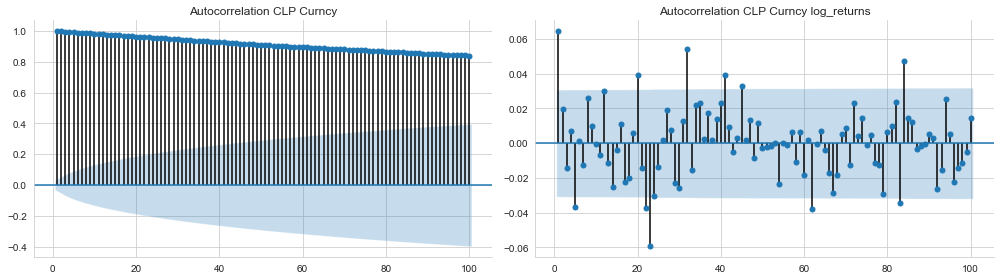

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
sns.histplot(df.loc[:,target],ax=ax2,kde=True)
ax1.set_title(target)
ax1.plot(df.index, df.loc[:,target],label="Precio")
ax1.plot(dfma.index,dfma.loc[:,target+" Media_móvil_{}_días".format(ventana_tiempo_media_movil)],label="Media móvil {} días".format(ventana_tiempo_media_movil))
ax1.legend()
ax1.set_xlabel('Dates')
ax1.set_ylabel('Prices')
sns.despine()
fig.tight_layout();

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
sns.histplot(dflog.loc[:,target+" log_returns"],ax=ax2,kde=True,stat="density")
ax1.text(x=.05, y=.9,s=f'Mean: {dflog.loc[:,target+" log_returns"].mean():8.2f}\nStd: {dflog.loc[:,target+" log_returns"].std():5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax1.transAxes)

ax1.set_title(target+" log_returns")
ax1.plot(dflog.index, dflog.loc[:,target+" log_returns"],label="Precio")
ax1.legend()
ax1.set_xlabel('Dates')
ax1.set_ylabel('Prices')
sns.despine()
fig.tight_layout();

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
plot_acf(df[target],ax=ax1, lags=100, zero=False, title='Autocorrelation {}'.format(target))
plot_acf(dflog[target+" log_returns"].dropna(),ax=ax2, lags=100, zero=False, title='Autocorrelation {}'.format(target+" log_returns"))
sns.despine()
fig.tight_layout();

## Esto para log returns

In [4]:
dftest=dflog_test
target=target+" log_returns"   

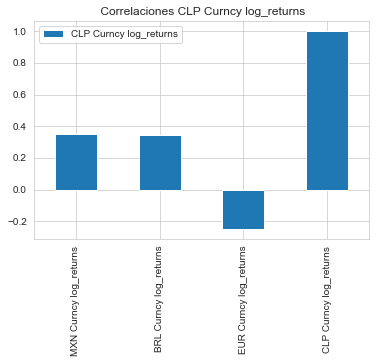

In [7]:
pd.DataFrame(dftest.corr().loc[target]).plot.bar(title=f" Correlaciones {target}")

# Definición funciones clasificación

In [42]:
def train_test_split(X,Y,dias_a_predecir,ventanadetiempo,dias_atras):
    if dias_atras<dias_a_predecir:
        x_train=X.iloc[dias_atras+1:ventanadetiempo+dias_atras+1]
        x_test=X.iloc[:dias_atras+1]
        y_train=Y.iloc[dias_atras+1:ventanadetiempo+dias_atras+1]        
        y_test=Y.iloc[:dias_atras+1]
    else:
        x_train=X.iloc[dias_a_predecir::]
        x_test=X.iloc[:dias_a_predecir]
        y_train=Y.iloc[dias_a_predecir::]        
        y_test=Y.iloc[:dias_a_predecir]
    return(x_train,x_test,y_train,y_test)

In [46]:
def reglineal(x_train,x_test,y_train,y_test,modelo_de_regresión):
    pipe=Pipeline(steps=[('scaler', StandardScaler()),])
    x_train=pd.DataFrame(pipe.fit_transform(x_train))
    x_test=pd.DataFrame(pipe.transform(x_test))
    #valores_x_actuales=pd.DataFrame(x_test.iloc[-1]).transpose()   
    valor_y_actual=y_test.iloc[-1]
    reg_lineal = modelo_de_regresión.fit(x_train, y_train)    # predict_proba
   # coeficientes_reg_lineal=1 #pd.DataFrame(reg_lineal.coef_).transpose()
    valores_predichos=reg_lineal.predict(x_test)                        #PRIMERA PARTE ESTA BIEN, QUIZAS HACER UN PIPELINE
    #probabilidad_y=1 #(reg_lineal.predict_proba(x_test))[-1]
    accuracy_score_test=accuracy_score(y_test,valores_predichos)      # VER LO DE LA ESTANDARIZACION DE LOS TEST SET Y TODO ESO
    accuracy_score_train=accuracy_score(y_train,reg_lineal.predict(x_train))    #VER COMO PASAR LOS DATOS AFUERA DE LA FUNCION, QUIZAS UN DATAFRAME
    reg_lineal_score_train_precision=precision_score(y_train,reg_lineal.predict(x_train))
    reg_lineal_score_test_precision=precision_score(y_test,valores_predichos)
    errores_accuracy=np.array([accuracy_score_train,accuracy_score_test])
    errores_precision=np.array([reg_lineal_score_train_precision,reg_lineal_score_test_precision])
    fairvalue_actual=valores_predichos[-1]  
    return(fairvalue_actual,coeficientes_reg_lineal,errores_precision,errores_accuracy,reg_lineal,valor_y_actual,probabilidad_y)

In [7]:
def reglineal_summary(x_train,y_train,modelo_de_clasificación):
    lista_features=list(x_train.columns.values)
    pipe=Pipeline(steps=[('scaler', StandardScaler()),])
    x_train=pd.DataFrame(pipe.fit_transform(x_train))
    x_train.columns=lista_features
    x_train.index=y_train.index
    model =sm.Logit(y_train,x_train)
    trained_model = model.fit()
    summary=trained_model.summary2()
    return(summary)

In [54]:
def iterar_fair_value_reg_lineal(dftest,ventanadetiempo,ventana_historia_hacia_atras,modelo_de_clasificación):
    i=0
    lista_fair_values=[]
    df_coeficientes=pd.DataFrame()
    lista_errores_precision_train=[]
    lista_errores_accuracy_train=[]
    lista_errores_precision_test=[]
    lista_errores_accuracy_test=[]
    lista_fit_modelo=[]
    f=[]
    g=[]
    X=dftest.iloc[:,:-1]
    Y=dftest.iloc[:,-1]
    lista_features=list(X.columns.values)
    while i<=ventana_historia_hacia_atras:
        if i<dias_a_predecir:
            train_test_set=train_test_split(X.iloc[::-1].iloc[:ventanadetiempo+dias_a_predecir],Y.iloc[::-1].iloc[:ventanadetiempo+dias_a_predecir],dias_a_predecir,ventanadetiempo,i)
            datos_modelo=reglineal(train_test_set[0],train_test_set[1],train_test_set[2],train_test_set[3],modelo_de_clasificación)
            if i==0:
                summary=reglineal_summary(train_test_set[0],train_test_set[2],modelo_de_clasificación)
            else:
                i=i
        else:
            train_test_set=(train_test_split(X.iloc[::-1].iloc[i-dias_a_predecir+1:ventanadetiempo+i+1],Y.iloc[::-1].iloc[i-dias_a_predecir+1:ventanadetiempo+i+1],dias_a_predecir,ventanadetiempo,i))
            datos_modelo=reglineal(train_test_set[0],train_test_set[1],train_test_set[2],train_test_set[3],modelo_de_clasificación)
        lista_fair_values.append(datos_modelo[0])
        #df_coeficientes=df_coeficientes.append(datos_modelo[1].transpose()) 
        lista_errores_precision_train.append(datos_modelo[2][0])
        lista_errores_accuracy_train.append(datos_modelo[3][0])
        lista_errores_precision_test.append(datos_modelo[2][1])
        lista_errores_accuracy_test.append(datos_modelo[3][1])
        lista_fit_modelo.append(datos_modelo[4])       #cambiar nombres a variables 
        f.append(datos_modelo[6])
        i+=1
    #df_coeficientes.columns=lista_features
    #df_coeficientes=df_coeficientes.iloc[::-1]
    #df_coeficientes.index=dftest.iloc[-ventana_historia_hacia_atras-1:,:].index
    #df_coeficientes=1
    df_fair_values=pd.DataFrame(lista_fair_values)
    df_fair_values.index=dftest.iloc[::-1].iloc[0:ventana_historia_hacia_atras+1,:].index
    df_prob_fair_values=pd.DataFrame(f)
    df_prob_fair_values.index=dftest.iloc[::-1].iloc[0:ventana_historia_hacia_atras+1,:].index
    df_prob_fair_values=df_prob_fair_values.iloc[::-1]
    data={"precision_train":lista_errores_precision_train,"precision_test":lista_errores_precision_test,"accuracy_train":lista_errores_accuracy_train,"accuracy_test":lista_errores_accuracy_test}
    df_errores=pd.DataFrame(data=data)
    df_errores.index=dftest.iloc[::-1].iloc[0:ventana_historia_hacia_atras+1,:].index
    return(df_fair_values,df_coeficientes,df_errores,lista_fit_modelo,df_prob_fair_values,summary)

In [9]:
def grafico_fair_value_vs_valor_actual(dftest,df_fair_values,df_prob_fair_values,ventana_historia_hacia_atras,ventanadetiempo,target):  # Aca el target esta en la ultima columna del dataframe
    std_hist_df=desv_estandar_historica_target(dftest,ventana_historia_hacia_atras,ventanadetiempo,target)
    values=dftest.iloc[-df_fair_values.shape[0]:,-1]
    df_values=values.to_frame()
    df_fair_value_valor_actual=pd.concat([df_values,df_prob_fair_values], axis=1)
    df_fair_value_valor_actual.columns.values[1]=target+" Predict"
    delta=df_fair_value_valor_actual[target]-df_fair_value_valor_actual[target+" Predict"]
    df_fair_value_valor_actual["Delta"]=delta
    fig, ax =plt.subplots(1,1)   
    data=[[dftest.iloc[-1,-1],df_fair_value_valor_actual.iloc[-1,1],df_fair_value_valor_actual.iloc[-1,-1]]]
    column_labels=["Valor actual", "Fair Value Actual", "Delta"]
    ax.axis('tight')
    ax.axis('off')
    table=ax.table(cellText=data,colLabels=column_labels,loc="center left")
    table.scale(2, 4)
    table.set_fontsize(32)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 7))
    fig.suptitle("Fairvalue y valor actual ")
    ax2.plot(df_fair_value_valor_actual.index, df_fair_value_valor_actual["Delta"])
    ax1.plot(df_fair_value_valor_actual.index, df_fair_value_valor_actual[target+" Predict"],label=target+" Predict")
    ax1.plot(df_fair_value_valor_actual.index, df_fair_value_valor_actual[target],label=target)
    ax1.fill_between(std_hist_df.index,-std_hist_df.iloc[:,0]+df_fair_value_valor_actual[target] , std_hist_df.iloc[:,0]+df_fair_value_valor_actual[target], color='green', alpha=.2)
    ax1.legend(loc="upper right")
    ax1.tick_params(labelrotation=90)     
    ax2.tick_params(labelrotation=90)
    ax1.set_title('Fair Value v/s valor realizado')
    ax2.set_title('Delta')
    ax2.text(x=.05, y=.9,s=f"Correlation: {df_fair_value_valor_actual.corr().iloc[0,1]:5.2f}",transform=ax2.transAxes)
    sns.despine()
    plt.show()
    ax1=sns.histplot(df_fair_value_valor_actual.loc[:,"Delta"],kde=True)
    ax2=sns.jointplot(x=target, y=target+" Predict",robust=True, ci=None,line_kws={'lw': 1, 'color': 'k'},scatter_kws={'s': 1},data=df_fair_value_valor_actual,kind='reg') 
    delta_std=df_fair_value_valor_actual["Delta"].std()
    delta_media=df_fair_value_valor_actual["Delta"].mean()
    ax1.text(x=.05, y=.9,s=f'Media: {delta_media:8.2f}\nStd: {delta_std:5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax1.transAxes)
    f = plt.figure()
    sns.despine()
    plt.show()
    return(df_fair_value_valor_actual)

In [10]:
def desv_estandar_historica_target(dftest,ventana_historia_hacia_atras,ventanadetiempo,target):
    target_df=dftest.loc[:,target]
    std_hist_df=target_df.rolling(ventanadetiempo).std()
    std_hist_df=pd.DataFrame(std_hist_df.iloc[-ventana_historia_hacia_atras-1:])
    std_hist_df=std_hist_df.rename(columns={target:"Desv Estandar historica "+target})
    return((std_hist_df))

In [11]:
def grafico_coeficientes(df_coeficientes):
    df_coeficientes=df_coeficientes.div(abs(df_coeficientes).sum(axis=1), axis=0)*100
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 7))
    fig.suptitle('Coeficientes')
    ax2.plot=(df_coeficientes.iloc[-1,:]).plot.bar()
    ax1.plot(df_coeficientes.index,df_coeficientes.iloc[:,:])
    ax1.legend((list(df_coeficientes.columns.values)),loc="upper right")
    ax1.tick_params(labelrotation=90)            #hacer que fechas se vean en otro formato 
    ax2.tick_params(labelrotation=90) 
    ax1.set_title('Coeficientes en el tiempo')
    ax2.set_title('Coeficientes actualmente')
    sns.despine()
    plt.show()

In [12]:
def gráfico_precision_accuracy(dftest,df_errores,ventanadetiempo,dias_a_predecir):
    n=(ventanadetiempo)
    p=dftest.shape[1]  
    fig, (plot_precision, plot_adjusted_accuracy) = plt.subplots(1, 2,figsize=(15, 7))
    fig.suptitle('Errores')
    plot_adjusted_accuracy.plot(df_errores.index,df_errores.iloc[:,2:],label={"Error Train","Error Test"})
    plot_precision.plot(df_errores.index,df_errores.iloc[:,0:2])
    
    plot_precision.tick_params(labelrotation=90)         #hacer que fechas se vean en otro formato 
    plot_adjusted_accuracy.tick_params(labelrotation=90)
    plot_precision.set_title(' Precision')
    plot_precision.legend(list(df_errores.iloc[:,0:2].columns.values),loc="upper right")
    plot_adjusted_accuracy.legend(list(df_errores.iloc[:,2:].columns.values),loc="upper right")
    plot_adjusted_accuracy.set_title(' Accuracy')
    plot_precision.axvline(x =df_errores.index[dias_a_predecir] , color = 'r',linestyle="--", label = 'axvline - full height')
    plot_adjusted_accuracy.axvline(x = df_errores.index[dias_a_predecir] , color = 'r',linestyle="--", label = 'axvline - full height')
    sns.despine()
    plt.show()

In [13]:
def roc_auc_plot(Y,Y_prob):
    fpr, tpr, threshold =roc_curve(Y,Y_prob)
    print("ROC AUC= %.3f" % (roc_auc_score(Y,Y_prob)))
    plt.plot(fpr, tpr, marker='.', label="modelo")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Regresión Logistica

In [61]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [15]:
modelo_de_clasificación=LogisticRegression(penalty="none")
df_logistic_regression=dftest
#df_logistic_regression=dftest.diff().dropna()
df_logistic_regression.iloc[:,-1]=df_logistic_regression.iloc[:,-1].apply(lambda x: 1 if(x>0) else 0)

In [67]:
modelo_de_clasificación=GradientBoostingClassifier( random_state = 0)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\augus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimization terminated successfully.
         Current function value: 0.594433
         Iterations 5


C:\Users\augus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


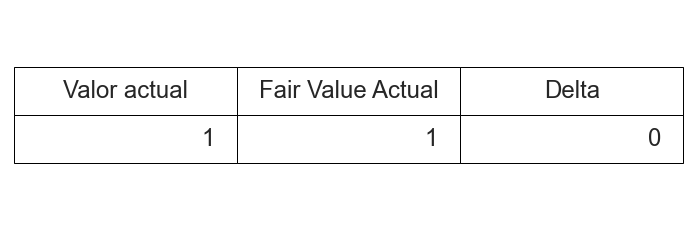

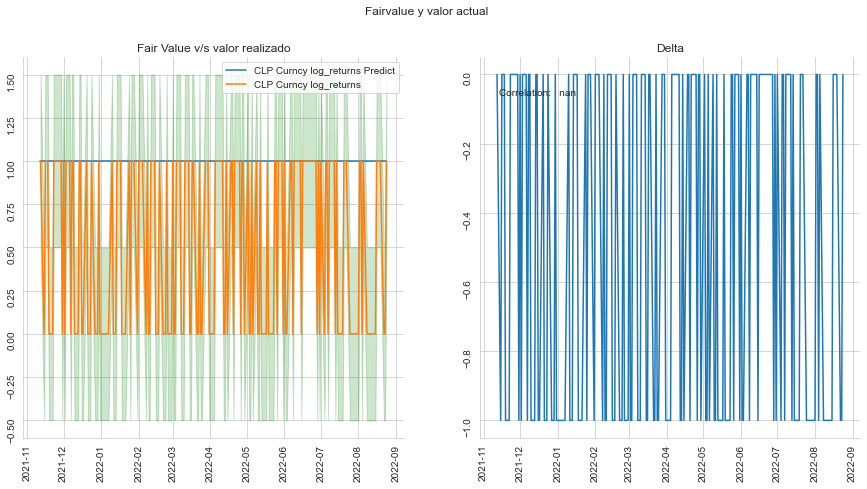

C:\Users\augus\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


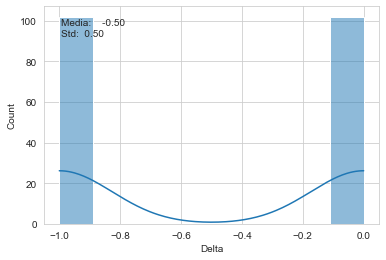

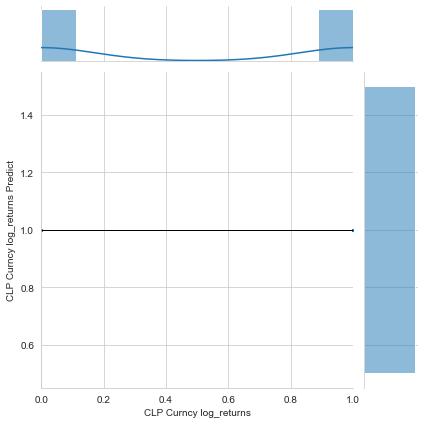

<Figure size 432x288 with 0 Axes>

<ipython-input-68-fe668e087d31>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fair["valores"]=pd.DataFrame(dftest.iloc[-fair_value_en_ventana_tiempo[0].shape[0]:,-1])


In [68]:
fair_value_en_ventana_tiempo=iterar_fair_value_reg_lineal(df_logistic_regression,ventanadetiempo,ventana_historia_hacia_atras,modelo_de_clasificación)
df_fair_values=fair_value_en_ventana_tiempo[0]
df_fair_value_valor_actual=grafico_fair_value_vs_valor_actual(df_logistic_regression,df_fair_values,fair_value_en_ventana_tiempo[4],ventana_historia_hacia_atras,ventanadetiempo,target)
h_r=0
diff_lgr=df_fair_value_valor_actual
for i in range(0,df_fair_value_valor_actual.shape[0]):
    if diff_lgr.iloc[i,0]>0 and diff_lgr.iloc[i,1]>0:
        h_r+=1
    elif diff_lgr.iloc[i,0]<0 and diff_lgr.iloc[i,1]<0:
        h_r+=1
    else:
        h_r=h_r
h_r=(h_r/(df_fair_value_valor_actual.shape[0]-1))
df_fair=fair_value_en_ventana_tiempo[0].iloc[::-1]
df_fair["valores"]=pd.DataFrame(dftest.iloc[-fair_value_en_ventana_tiempo[0].shape[0]:,-1])
#df_fair["Delta"]=df_fair.iloc[:,1]-df_fair.iloc[:,0]
df_resultados=pd.DataFrame(fair_value_en_ventana_tiempo[2].mean())
df_resultados.index+=" mean"
df_resultados_std=pd.DataFrame(fair_value_en_ventana_tiempo[2].std())
df_resultados_std.index+=" std"
#df_resultados1=pd.DataFrame(data=[abs(df_fair.iloc[:,2]).mean(),abs(df_fair.iloc[:,2]).std(),df_fair.iloc[:,2].mean(),df_fair.iloc[:,2].std(),df_fair.corr().iloc[0,1],h_r],index=["abs mean","abs std","mean","std","corr","Hit Ratio"])
df_resultados=pd.concat([df_resultados,df_resultados_std])
df_resultados.rename(columns = {0:str(modelo_de_clasificación)}, inplace = True)
df_fair.iloc[:,1].std()
df_resultados_totales=pd.concat([df_resultados_totales,df_resultados], axis=1)

In [70]:
df_resultados_totales.to_excel("resultados log clasificacion.xlsx")

C:\Users\augus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\augus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimization terminated successfully.
         Current function value: 0.594433
         Iterations 5


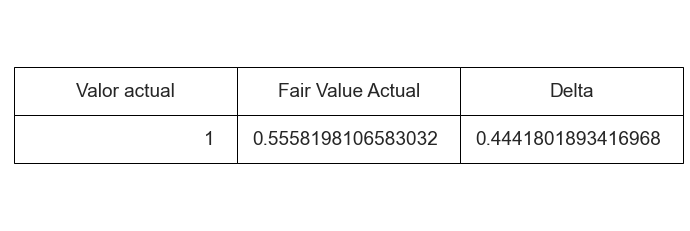

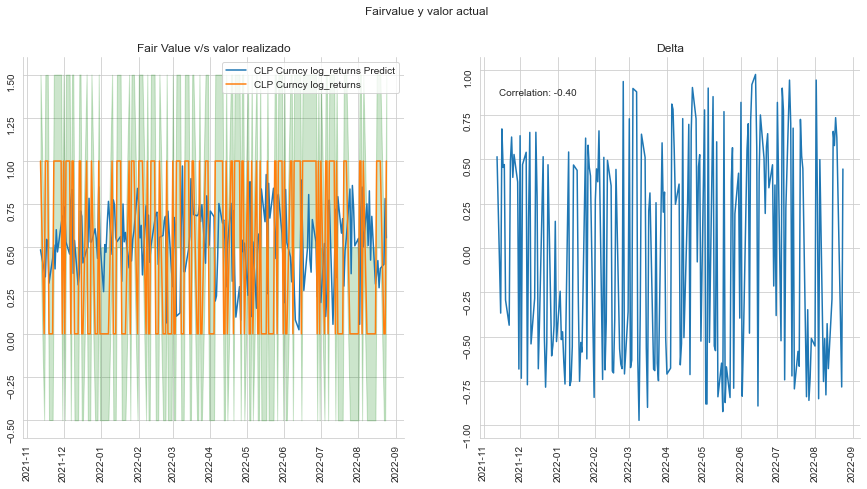

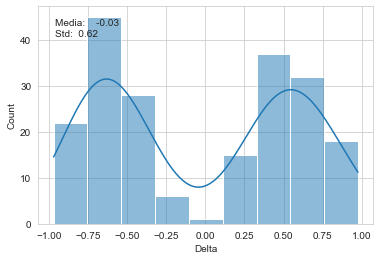

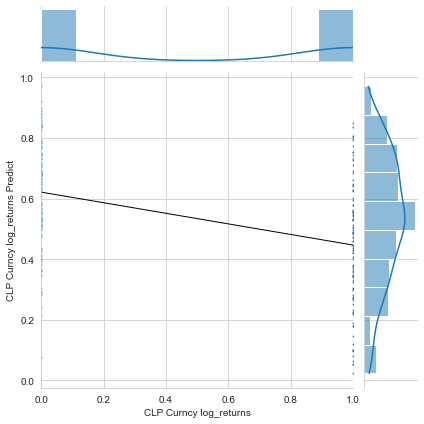

<Figure size 432x288 with 0 Axes>

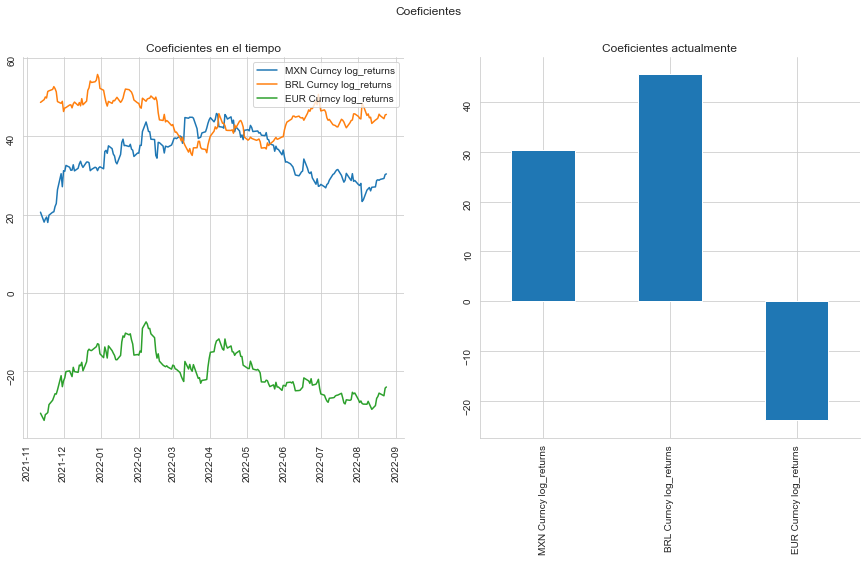

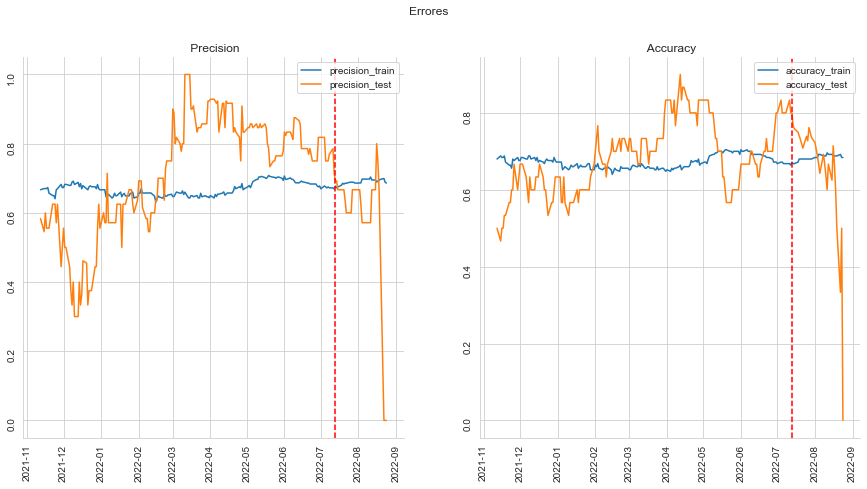

                            Results: Logit
Model:              Logit                  Pseudo R-squared: 0.142     
Dependent Variable: CLP Curncy log_returns AIC:              303.2166  
Date:               2022-11-16 08:51       BIC:              313.7810  
No. Observations:   250                    Log-Likelihood:   -148.61   
Df Model:           2                      LL-Null:          -173.28   
Df Residuals:       247                    LLR p-value:      1.9308e-11
Converged:          1.0000                 Scale:            1.0000    
No. Iterations:     5.0000                                             
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
MXN Curncy log_returns   0.4071   0.1827  2.2289 0.0258  0.0491  0.7651
BRL Curncy log_returns   0.6100   0.1719  3.5477 0.0004  0.2730  0.9469
EUR Curncy log_return

In [16]:
fair_value_en_ventana_tiempo=iterar_fair_value_reg_lineal(df_logistic_regression,ventanadetiempo,ventana_historia_hacia_atras,modelo_de_clasificación)
df_fair_values=fair_value_en_ventana_tiempo[0]
lista_coeficientes=fair_value_en_ventana_tiempo[1]
df_errores=fair_value_en_ventana_tiempo[2]
df_fair_value_valor_actual=grafico_fair_value_vs_valor_actual(df_logistic_regression,df_fair_values,fair_value_en_ventana_tiempo[4],ventana_historia_hacia_atras,ventanadetiempo,target)
grafico_coeficientes(fair_value_en_ventana_tiempo[1])
gráfico_precision_accuracy(dftest,df_errores,ventanadetiempo,dias_a_predecir)
print(fair_value_en_ventana_tiempo[5])

In [20]:
fair_value_en_ventana_tiempo[4].join(df_logistic_regression.iloc[-fair_value_en_ventana_tiempo[4].shape[0]:,-1])

,0,1,CLP Curncy log_returns
Dates,,,
2021-11-12,0.486469,0.513531,1
2021-11-15,0.367032,0.632968,0
2021-11-16,0.329891,0.670109,1
2021-11-17,0.546644,0.453356,1
2021-11-18,0.530739,0.469261,1
...,...,...,...
2022-08-18,0.266563,0.733437,1
2022-08-19,0.378364,0.621636,1
2022-08-22,0.402264,0.597736,0


ROC AUC= 0.729


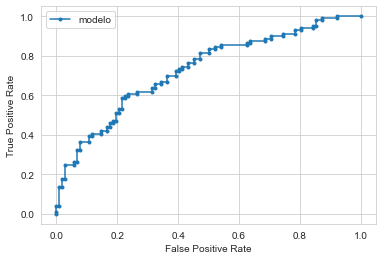

In [20]:
roc_auc_plot(df_logistic_regression.iloc[-fair_value_en_ventana_tiempo[4].shape[0]:,-1],pd.DataFrame(fair_value_en_ventana_tiempo[4].iloc[:,1]))

In [17]:
def confusion_matrix_plot(Y,Y_pred):
    tn, fp, fn, tp = confusion_matrix(list(Y), list(Y_pred), labels=[0, 1]).ravel()
    print('True Positive:', tp)
    print('True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    ConfusionMatrixDisplay(confusion_matrix(Y, Y_pred,normalize="true")).plot(cmap='Greys')
    print("Precision score:",precision_score(Y, Y_pred))
    print(classification_report(Y, Y_pred))

In [23]:
df_fair_value_valor_actual["Valor Predicho"]=df_fair_value_valor_actual.iloc[:,2].apply(lambda x: 1 if(x>0.5) else 0)

True Positive: 60
True Negative: 80
False Positive: 22
False Negative: 42
Precision score: 0.7317073170731707
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       102
           1       0.73      0.59      0.65       102

    accuracy                           0.69       204
   macro avg       0.69      0.69      0.68       204
weighted avg       0.69      0.69      0.68       204



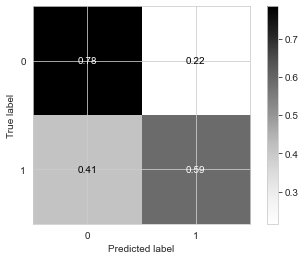

In [28]:
confusion_matrix_plot(df_fair_value_valor_actual.iloc[:,0],df_fair_value_valor_actual.iloc[:,4])

In [27]:
df_new=df

In [26]:
import quantstats
quantstats.extend_pandas()

In [144]:
def preprocesamiento(dataframe_datos):
    dataframe_datos_procesados=dataframe_datos
    return(dataframe_datos_procesados)

def regla_trading(dataframe_precio_actual,dataframe_datos,comision,dataframe_trades_anteriores,fecha_actual):
    cantidad=(dataframe_datos.loc[str(fecha_actual)]*2-1)

    #if dataframe_datos.loc[str(fecha_actual)]>=0.8:
     #   cantidad=0.1
    #if dataframe_datos.loc[str(fecha_actual)]<=0.2:
     #   cantidad=-0.1
    #else:
    cantidad=1
    return(cantidad)   # Cantidad a comprar

    
class Estrategia:
    def __init__(self ,dataframe_precio):
        self.comision=0
        self.dataframe_precio=dataframe_precio
        
    def add_comision(self,comision):
        self.comision=comision
        
    def add_datos(self,dataframe_datos):
        self.dataframe_datos=preprocesamiento(dataframe_datos)
        
    def run(self):   #dataframe_datos tiene que ser serie de tiempo
        self.dataframe_trades_anteriores=pd.DataFrame()
        self.dataframe_cantidad_comprada=pd.DataFrame()
        self.dataframe_pnl=pd.DataFrame()
        self.dataframe_precio=self.dataframe_precio.iloc[-self.dataframe_datos.shape[0]:]
        for i in self.dataframe_precio.index:
            dataframe_precio_actual=self.dataframe_precio.loc[:i]    # ver los datos para forward looking # cortar dataframe_datos
            accion_actual=regla_trading(dataframe_precio_actual,self.dataframe_datos,self.comision,self.dataframe_trades_anteriores,i)
            self.dataframe_trades_anteriores=self.dataframe_trades_anteriores.append(pd.DataFrame([accion_actual],index=[i]))
            cantidad_comprada=accion_actual
            self.dataframe_cantidad_comprada=self.dataframe_cantidad_comprada.append(pd.DataFrame([cantidad_comprada],index=[i]))
        self.dataframe_cantidad_comprada.columns=["Cantidad Comprada"]
        self.dataframe_pnl=dataframe_precio_actual.merge(self.dataframe_cantidad_comprada, how='outer', left_index=True, right_index=True)
        self.dataframe_pnl["Cantidad Comprada acomulada"]=self.dataframe_pnl["Cantidad Comprada"].cumsum()
        self.dataframe_pnl["Comision"] = self.dataframe_pnl["Cantidad Comprada"].apply(lambda x: self.comision if(x!=0) else 0)
        self.dataframe_pnl=self.dataframe_pnl.assign(Dinero_usado=lambda x: x.iloc[:,0]*x["Cantidad Comprada"]+x["Comision"])
        self.dataframe_pnl["Dinero usado total"]=self.dataframe_pnl["Dinero_usado"].cumsum()
        self.dataframe_pnl["Pnl hasta la fecha"]=self.dataframe_pnl["Cantidad Comprada acomulada"]*self.dataframe_pnl.iloc[:,0]-self.dataframe_pnl["Dinero usado total"]
        self.dataframe_pnl_vector=self.dataframe_pnl["Pnl hasta la fecha"]
        self.dataframe_pnl_vector_diff=self.dataframe_pnl_vector.diff()
    def add_benchmark(self,benchmark):
        self.benchmark=benchmark

    def plot(self,dt):
        dataframe_pnl_dt=self.dataframe_dt(dt)
        self.stats(dataframe_pnl_dt)
        fig, ax =plt.subplots(1,1)  
        data=[[self.hit_ratio,self.statistics[2],(self.statistics[3])**(1/2),self.sharpe_ratio,self.statistics[4],self.statistics[5]]]
        column_labels=["Hit ratio","Mean", "Standard deviation","Sharpe Ratio","Skew","Kurtosis"]
        ax.axis('tight')
        ax.axis('off')
        table=ax.table(cellText=data,colLabels=column_labels,loc="center")
        table.scale(4, 6)
        table.set_fontsize(64)
        fig, ax =plt.subplots(1,1)   
        data=[[self.daily_max_drawdown,self.max_drawdown,self.var_5,self.var_1]]
        column_labels=["1 period Max Drawdown","Max Drawdown","VAR 5%","VAR 1%"]
        ax.axis('tight')
        ax.axis('off')
        table=ax.table(cellText=data,colLabels=column_labels,loc="center")
        table.scale(4, 6)
        table.set_fontsize(64)
        
        fig,(ax1) = plt.subplots(ncols=1, figsize=(12,6))
        ax1=sns.histplot(dataframe_pnl_dt,kde=True).set(title='Histograma Pnl')
        fig,(ax1) = plt.subplots(ncols=1, figsize=(12,6))
        ax1=plt.plot(dataframe_pnl_dt.cumsum().index,dataframe_pnl_dt.cumsum())
        plt.xticks(rotation=90)
        plt.title("Pnl Acomulado")
        fig,(ax1) = plt.subplots(ncols=1, figsize=(12,6))
        ax1=plt.plot(self.drawdown.index,self.drawdown)
        plt.xticks(rotation=90)
        plt.title("DrawDowns")
        
        fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))
        self.var_5_dataframe_20_periods.plot(ax=ax1,title="Var 5% 20 Periodos")
        ax1.text(x=.05, y=.9,s=f'Worst 5%: {self.var_5_dataframe_20_periods.quantile(0.05):5.2f}\n Worst 1%: {self.var_5_dataframe_20_periods.quantile(0.01):5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax2.transAxes)
        
        self.var_5_dataframe_250_periods.plot(ax=ax2,title="Var 5% 250 Periodos")
        #ax1.text(x=.05, y=.9,s=f'Worst 5%: {self.var_5_dataframe_20_periods.quantile(0.05):5.2f}\n Worst 1%: {self.var_5_dataframe_20_periods.quantile(0.01):5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax2.transAxes)
        ax2.text(x=.05, y=.9,s=f'Worst 5%: {self.var_5_dataframe_250_periods.quantile(0.05):5.2f}\n Worst 1%: {self.var_5_dataframe_250_periods.quantile(0.01):5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax2.transAxes)
        plt.xticks(rotation=90)
        
        fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))
        self.var_1_dataframe_20_periods.plot(ax=ax1,title="Var 1% 20 Periodos")
        self.var_1_dataframe_250_periods.plot(ax=ax2,title="Var 1% 250 Periodos")
        plt.xticks(rotation=90)
        ax1.text(x=.05, y=.9,s=f'Worst 5%: {self.var_1_dataframe_20_periods.quantile(0.05):5.2f}\n Worst 1%: {self.var_1_dataframe_20_periods.quantile(0.01):5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax2.transAxes)
        ax2.text(x=.05, y=.9,s=f'Worst 5%: {self.var_1_dataframe_250_periods.quantile(0.05):5.2f}\n Worst 1%: {self.var_1_dataframe_250_periods.quantile(0.01):5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax2.transAxes)
        
        fig,(ax1) = plt.subplots(ncols=1, figsize=(12,6))
        self.desv_estandar_20_periodos.plot(ax=ax1,title="Desviación estándar 20 Periodos")
        plt.xticks(rotation=90)
        
        
    def dataframe_dt(self,dt):
        return(self.dataframe_pnl_vector.iloc[::dt].diff())    
    
    def stats(self,dataframe_pnl_vector_diff):
        self.sharpe_ratio=dataframe_pnl_vector_diff.mean()/dataframe_pnl_vector_diff.std()  # ver si usar log returns o diff en el pnl
        self.hit_ratio=[1 if i>0 else 0 for i in list(dataframe_pnl_vector_diff)]
        self.hit_ratio=mean(self.hit_ratio)
        self.statistics=describe(dataframe_pnl_vector_diff.dropna() , bias=False)
        self.var_5=dataframe_pnl_vector_diff.quantile(q=0.05)
        self.var_1=dataframe_pnl_vector_diff.quantile(q=0.01)
        self.var_5_dataframe_20_periods=dataframe_pnl_vector_diff.rolling(window=20).quantile(0.05)
        self.var_5_dataframe_250_periods=dataframe_pnl_vector_diff.rolling(window=250).quantile(0.05)
        self.var_1_dataframe_20_periods=dataframe_pnl_vector_diff.rolling(window=20).quantile(0.01)
        self.var_1_dataframe_250_periods=dataframe_pnl_vector_diff.rolling(window=250).quantile(0.01)
        self.drawdown=dataframe_pnl_vector_diff.apply(lambda x: x if x<=0 else np.nan).fillna(method="ffill").dropna()
        self.daily_max_drawdown=dataframe_pnl_vector_diff.cummin()[-1]
        
        roll_max=self.dataframe_pnl_vector_diff.rolling(window=250,min_periods=1).max()
        dd=estrategia_test.dataframe_pnl_vector_diff/roll_max-1.0
        max_drawdown=dd.rolling(window=250,min_periods=1).min()*roll_max
        self.max_drawdown=max_drawdown.iloc[-1]
        
        self.desv_estandar_20_periodos=self.dataframe_pnl_vector_diff.rolling(window=20).std()
        #returns=self.dataframe_pnl.iloc[:,0].pct_change()
        #self.precio_log_ret = np.log(1+returns) 

In [145]:
estrategia_test=Estrategia(pd.DataFrame(df_new.loc[:,f'{target.split(" ")[0]} {target.split(" ")[1]}']))
estrategia_test.add_datos(df_fair_value_valor_actual.iloc[:,2])
estrategia_test.run()

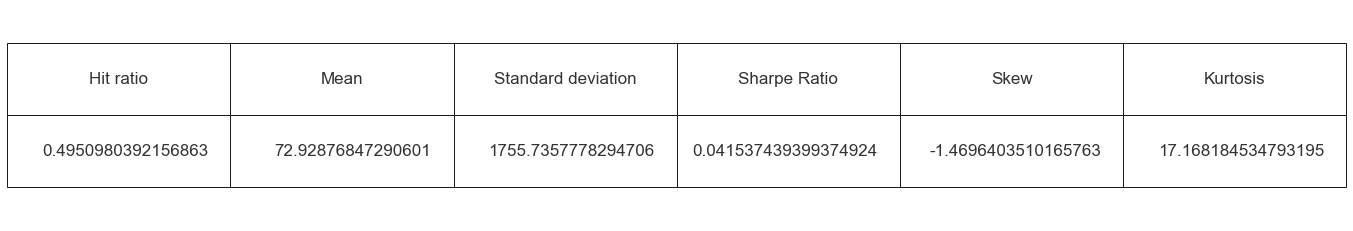

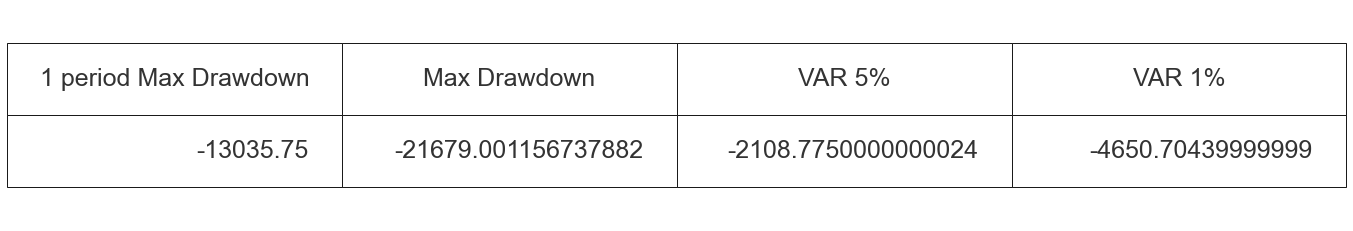

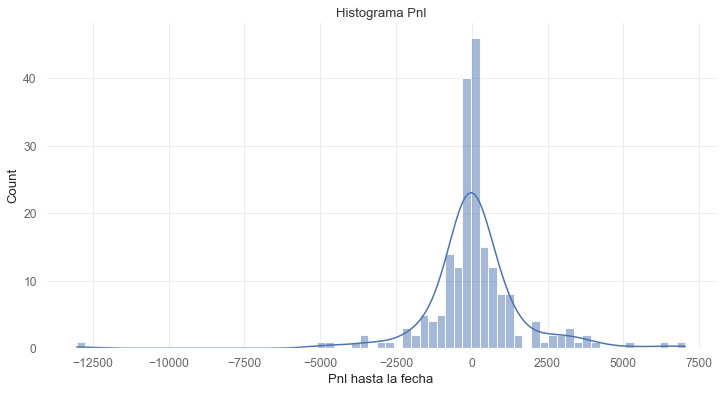

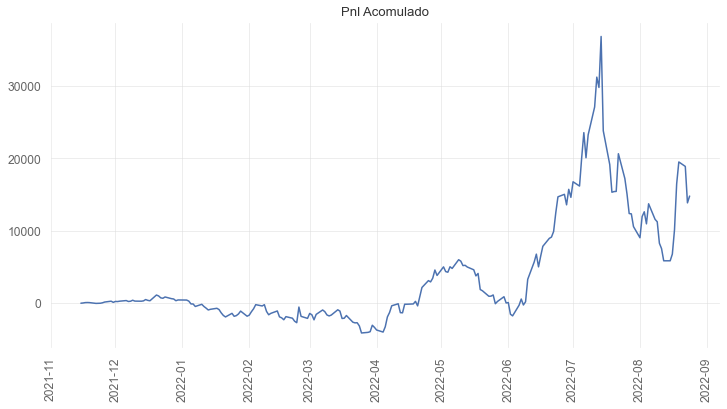

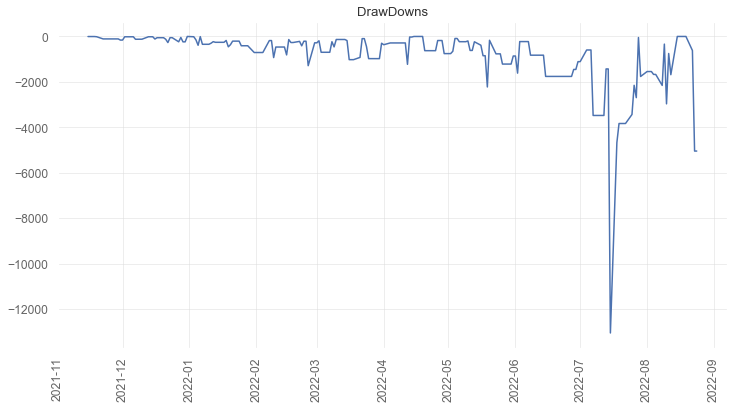

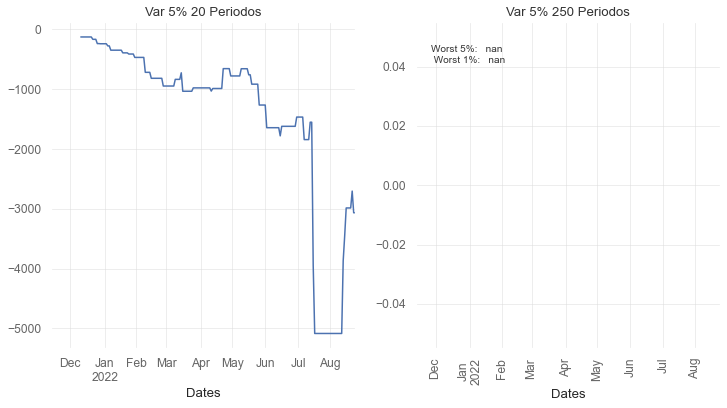

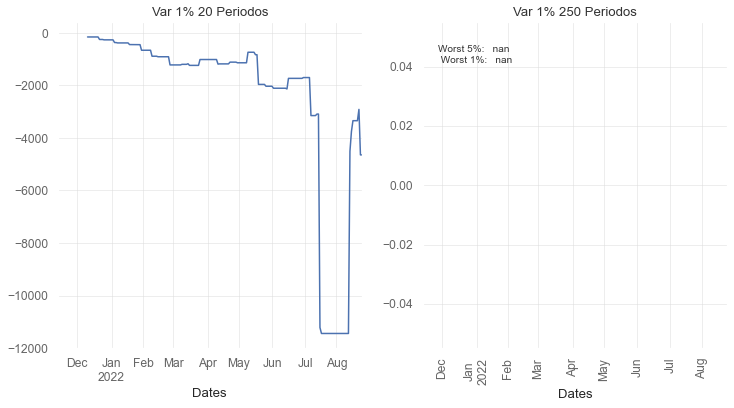

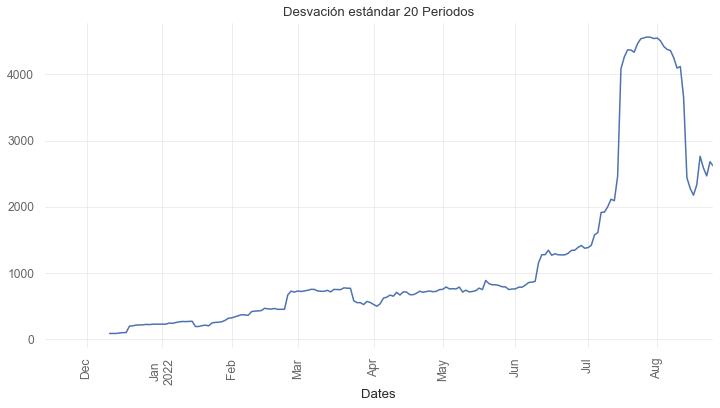

In [146]:
estrategia_test.plot(1)